## Boat Solved with DP

In [1]:
from package_RL_JBM import DynamicProgrammingSolver, PolicyPlotter_DP, GeosearchEnv, BoatEnvSimulator, GridWorldEnv, PolicyPlotter_MC, MonteCarloSolver

In [2]:
import gymnasium as gym
from gym import spaces
import numpy as np
import pygame

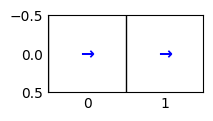

In [3]:
# Initialize the environments
boat_env = BoatEnvSimulator(east_wind_prob=0.7, west_wind_prob=0.3)


# Create solver instances
boat_solver = DynamicProgrammingSolver(boat_env, gamma=0.99, theta=0.01, use_value_iteration=True)

# Solve each environment
boat_policy, _ = boat_solver.solve()


# Plotting the optimal policies
# Adjust action symbols for the boat environment
boat_action_symbols = {0: '←', 1: '→'}
boat_plotter = PolicyPlotter_DP((1, 2), boat_policy, action_symbols=boat_action_symbols)
boat_plotter.plot()

## Gridworld Solved with DP

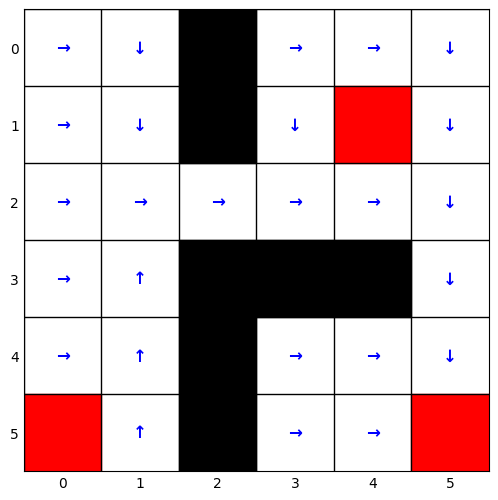

In [4]:
# Step 1: Initialize the Environment
env = GridWorldEnv(gamma=0.25)

# Step 2: Create the Solver
solver = DynamicProgrammingSolver(env, gamma=0.99, theta=0.01, use_value_iteration=True)

# Step 3: Solve the Environment
policy, value = solver.solve()

# Step 4: Visualize the policy
# Convert terminal states to a list of coordinates for the plotter
terminal_coords = list(env.terminal_states.keys())
# Pass walls directly as they are already in the correct format
plotter = PolicyPlotter_DP(env.grid_size, policy, walls=list(env.walls), terminal_states=terminal_coords)
plotter.plot()

## Gesearch solved with DP

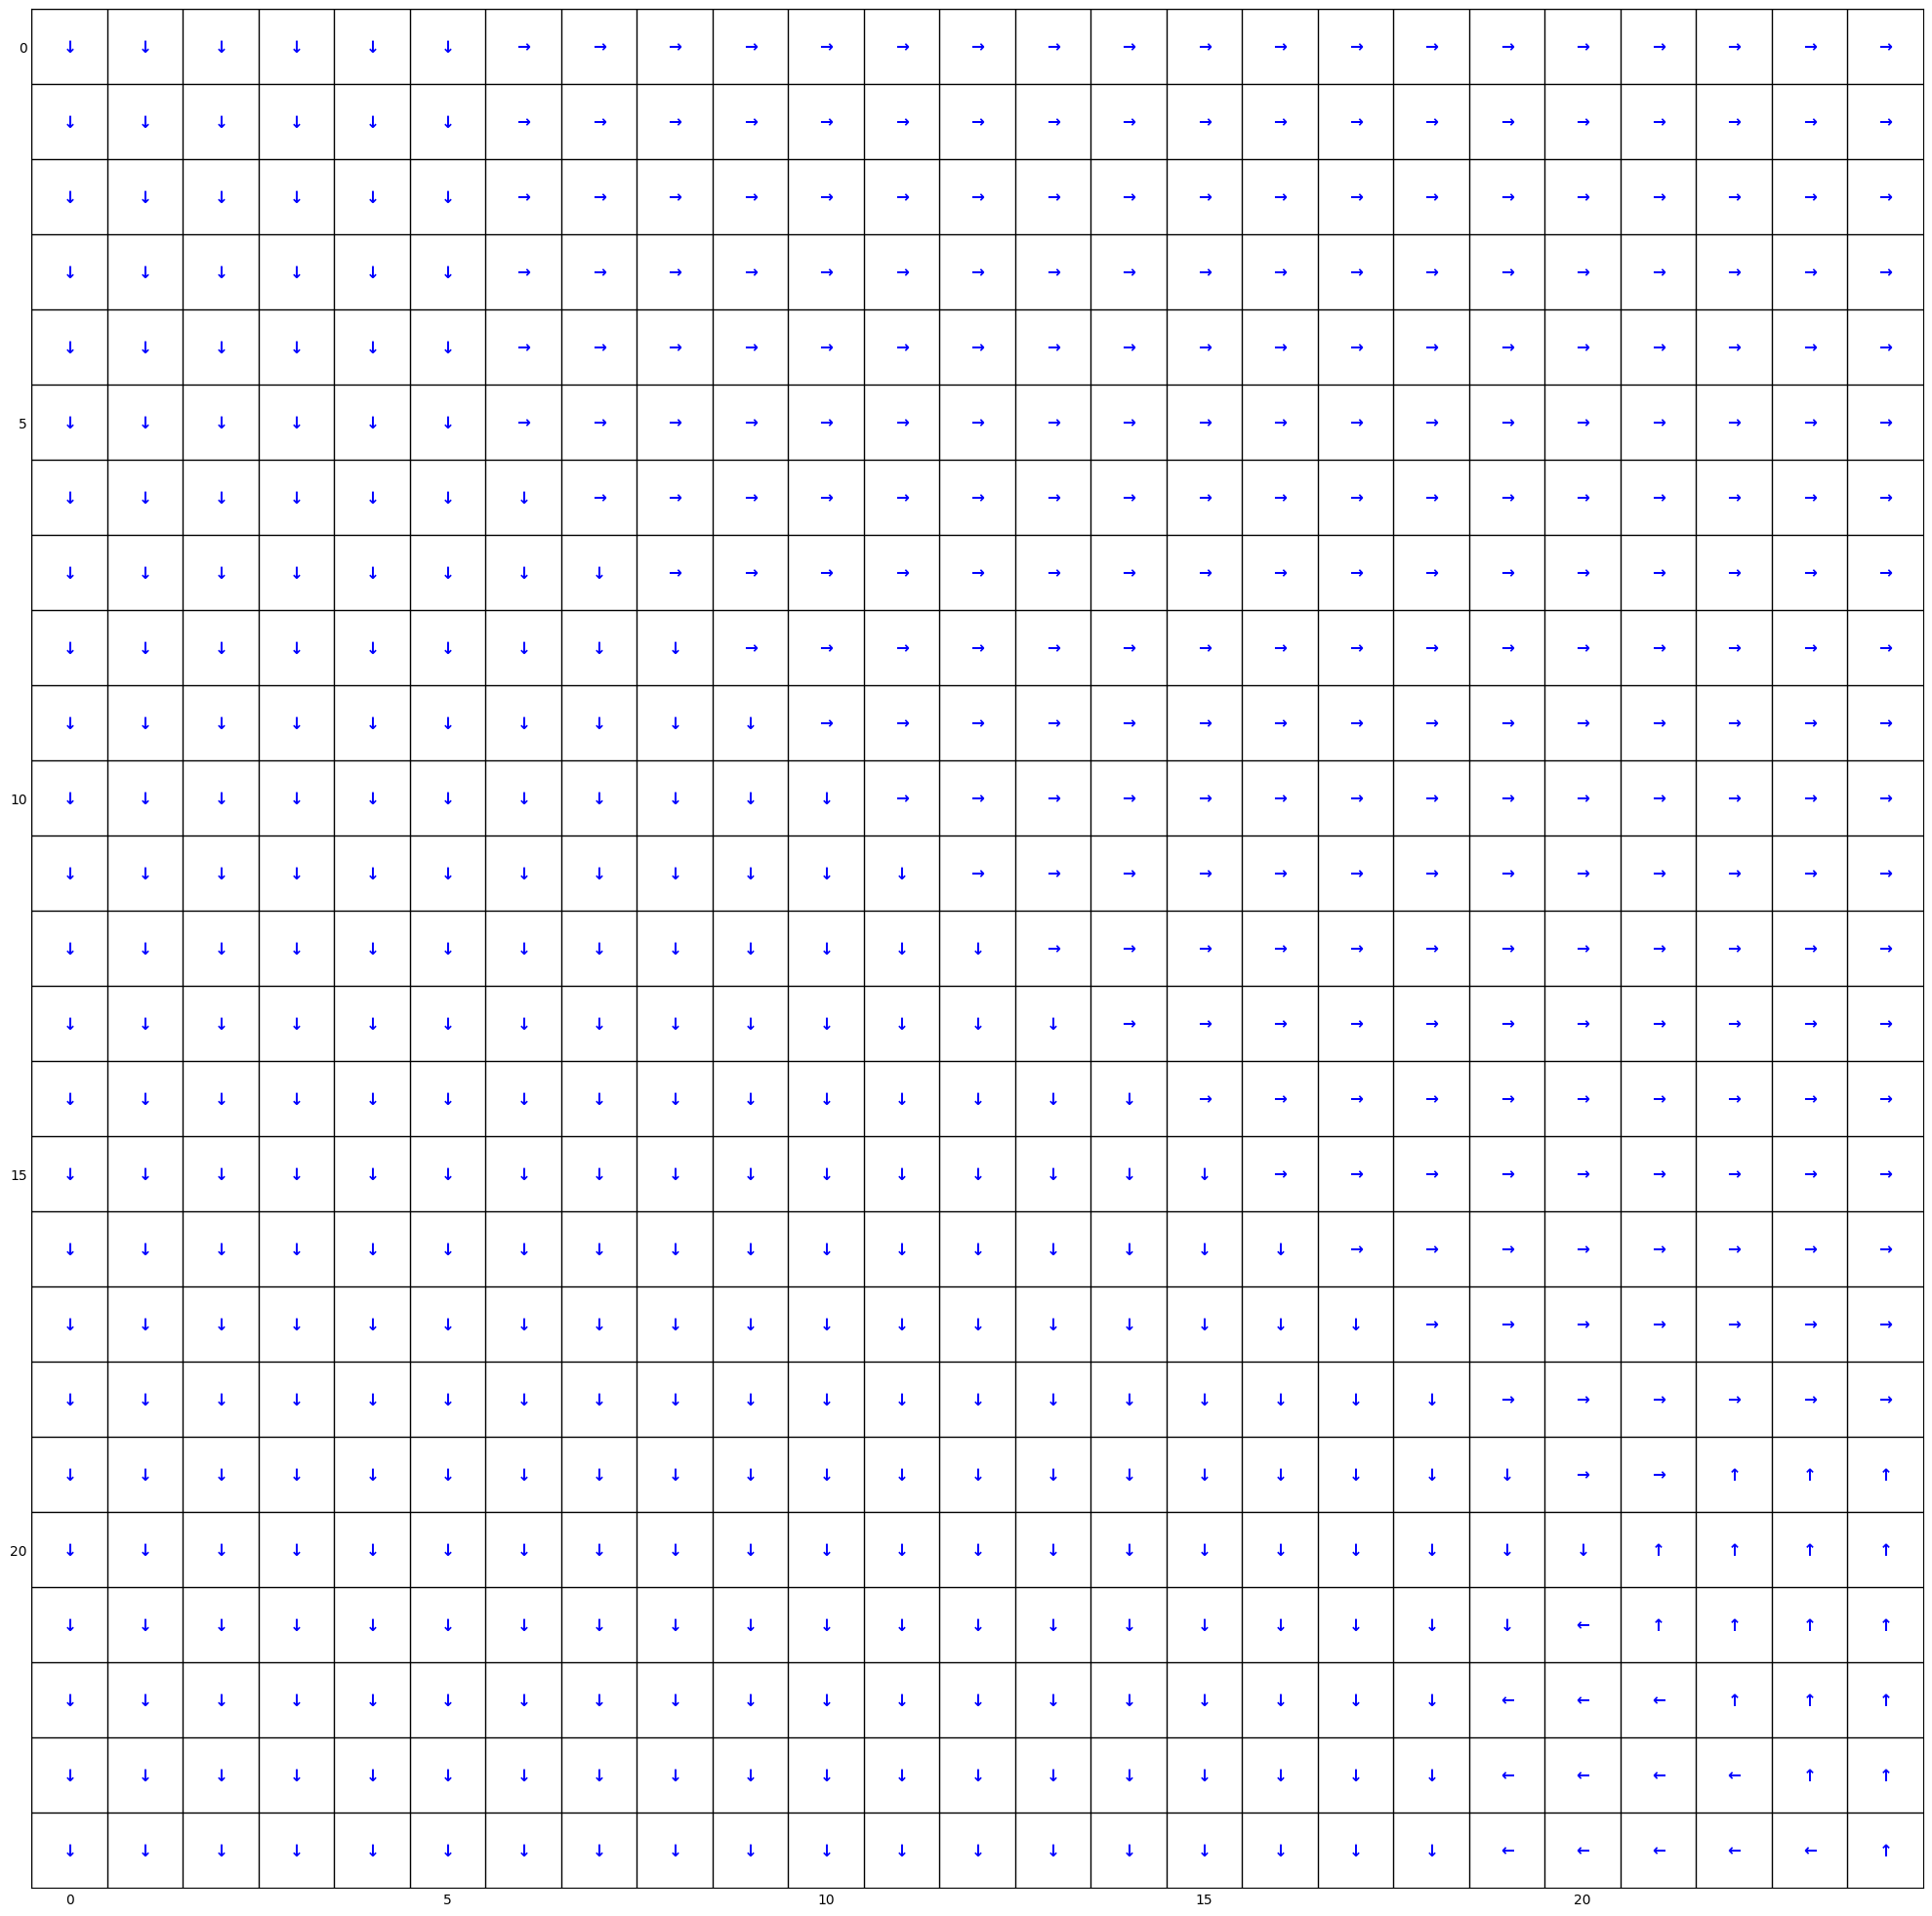

In [5]:
env = GeosearchEnv(A=0.75)
solver = DynamicProgrammingSolver(env, gamma=0.99, theta=0.01, use_value_iteration=True)
policy, value = solver.solve()

# Plot the policy
action_symbols = {0: '↑', 1: '↓', 2: '←', 3: '→'}  # For up, down, left, right

# Plot the policy using PolicyPlotter
plotter = PolicyPlotter_DP(grid_size=(env.grid_size, env.grid_size), 
                        policy=policy, 
                        walls=[],  # No walls in Geosearch
                        terminal_states=[],  # Add terminal states if defined
                        action_symbols=action_symbols)

plotter.plot()

## Boat Solved with MC

Policy after 0 episodes: {0: 1, 1: 1}
Policy after 100 episodes: {0: 1, 1: 1}
Policy after 200 episodes: {0: 0, 1: 0}
Policy after 300 episodes: {0: 1, 1: 1}
Policy after 400 episodes: {0: 0, 1: 1}


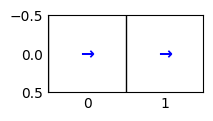

In [11]:
# Initialize environment
env = BoatEnvSimulator()

# Initialize the MonteCarloSolver with desired parameters
mc_solver = MonteCarloSolver(env, gamma=0.99, epsilon=0.1, exploring_starts=False, episodes=500)

# Run the Monte Carlo solver
policy = mc_solver.run()

# Plot the optimal policy using PolicyPlotter
boat_action_symbols = {0: '←', 1: '→'}
plotter = PolicyPlotter_MC((1, 2), policy, action_symbols=boat_action_symbols)
plotter.plot()


## Gridworld Solved with MC

Policy after 0 episodes: {0: 3, 1: 3, 2: 1, 3: 1, 4: 1, 5: 3, 6: 2, 7: 0, 8: 2, 9: 0, 10: 1, 11: 3, 12: 3, 13: 0, 14: 2, 15: 1, 16: 2, 17: 0, 18: 3, 19: 0, 20: 2, 21: 1, 22: 2, 23: 1, 24: 0, 25: 1, 26: 1, 27: 1, 28: 1, 29: 2, 30: 1, 31: 1, 32: 0, 33: 0, 34: 1, 35: 1}
Policy after 100 episodes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 1, 5: 2, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 2, 12: 2, 13: 2, 14: 1, 15: 0, 16: 0, 17: 2, 18: 1, 19: 0, 20: 1, 21: 1, 22: 1, 23: 2, 24: 2, 25: 0, 26: 1, 27: 3, 28: 1, 29: 2, 30: 0, 31: 3, 32: 1, 33: 1, 34: 0, 35: 1}
Policy after 200 episodes: {0: 0, 1: 1, 2: 2, 3: 1, 4: 1, 5: 2, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 2, 12: 3, 13: 1, 14: 1, 15: 0, 16: 3, 17: 2, 18: 2, 19: 0, 20: 0, 21: 3, 22: 1, 23: 2, 24: 1, 25: 0, 26: 2, 27: 1, 28: 1, 29: 2, 30: 0, 31: 3, 32: 1, 33: 1, 34: 0, 35: 1}
Policy after 300 episodes: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 2, 6: 1, 7: 2, 8: 2, 9: 0, 10: 1, 11: 2, 12: 3, 13: 1, 14: 1, 15: 0, 16: 3, 17: 2, 18: 2, 19: 0, 20: 0, 21: 3, 22: 1, 23: 2, 24: 1,

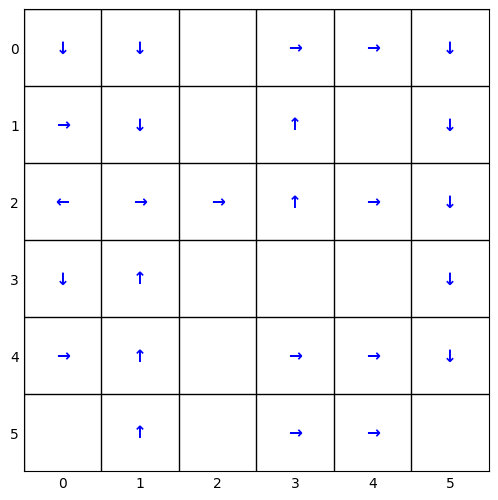

In [9]:
env = GridWorldEnv()
mc_solver = MonteCarloSolver(env, gamma=0.99, epsilon=0.1, exploring_starts=True, episodes=1000)
policy = mc_solver.run()
print("Final policy for GridWorldEnv:", policy)

plotter = PolicyPlotter_MC(env.grid_size, policy, walls=env.walls, terminal_states=env.terminal_states)
plotter.plot()

## Geosearch Solved with MC

Policy after 0 episodes: {0: 3, 1: 0, 2: 2, 3: 3, 4: 3, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 2, 11: 2, 12: 2, 13: 3, 14: 1, 15: 2, 16: 3, 17: 3, 18: 3, 19: 2, 20: 3, 21: 3, 22: 2, 23: 2, 24: 3, 25: 1, 26: 0, 27: 2, 28: 3, 29: 1, 30: 1, 31: 3, 32: 1, 33: 0, 34: 3, 35: 1, 36: 1, 37: 3, 38: 2, 39: 0, 40: 2, 41: 2, 42: 3, 43: 3, 44: 0, 45: 2, 46: 0, 47: 0, 48: 3, 49: 2, 50: 2, 51: 3, 52: 0, 53: 3, 54: 1, 55: 1, 56: 2, 57: 0, 58: 2, 59: 2, 60: 1, 61: 0, 62: 3, 63: 3, 64: 2, 65: 3, 66: 1, 67: 1, 68: 2, 69: 2, 70: 3, 71: 0, 72: 2, 73: 1, 74: 0, 75: 2, 76: 2, 77: 3, 78: 3, 79: 0, 80: 1, 81: 0, 82: 3, 83: 1, 84: 0, 85: 2, 86: 1, 87: 0, 88: 3, 89: 2, 90: 3, 91: 1, 92: 0, 93: 3, 94: 1, 95: 3, 96: 3, 97: 2, 98: 2, 99: 0, 100: 3, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 3, 111: 0, 112: 3, 113: 2, 114: 1, 115: 3, 116: 0, 117: 0, 118: 3, 119: 1, 120: 3, 121: 0, 122: 0, 123: 2, 124: 3, 125: 3, 126: 1, 127: 2, 128: 2, 129: 2, 130: 0, 131: 2, 132: 2, 133: 0, 134: 0, 135:

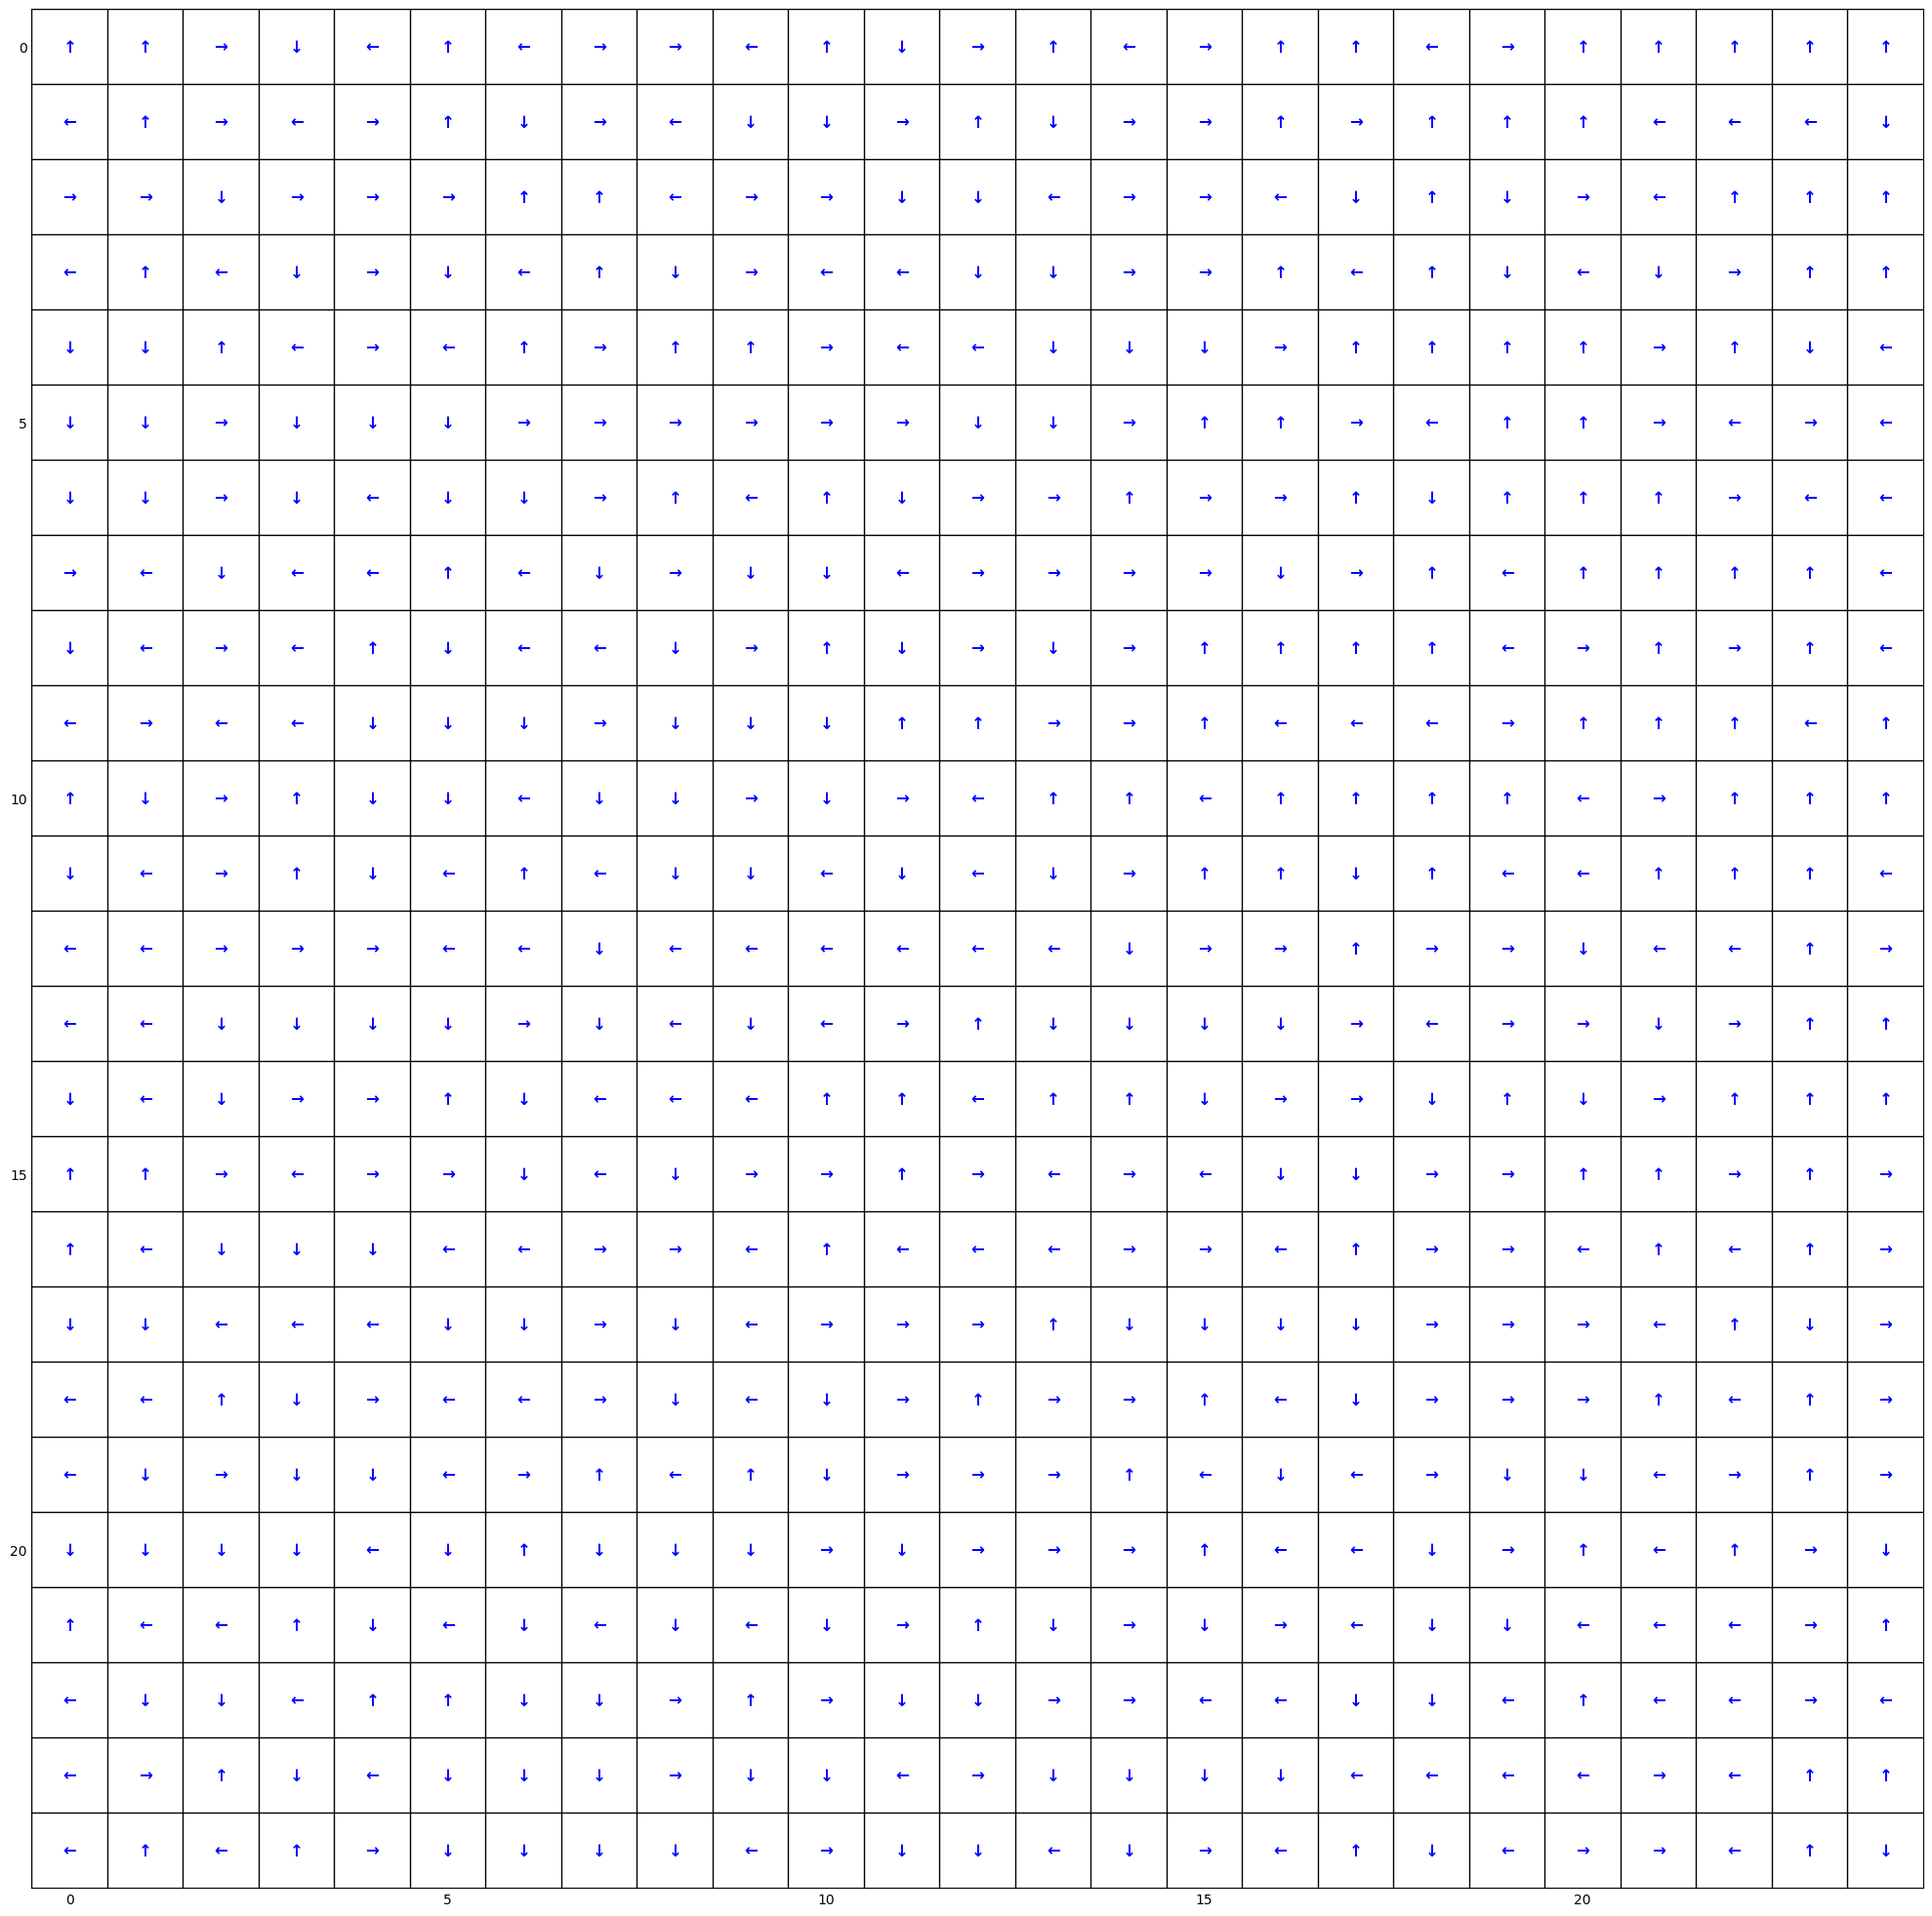

In [10]:
# Initialize the Geosearch environment
env = GeosearchEnv()

# Initialize the MonteCarloSolver with the parameters needed for Geosearch
mc_solver = MonteCarloSolver(env, gamma=0.99, epsilon=0.1, exploring_starts=True, episodes=1000)

# Run the Monte Carlo solver to compute the policy
policy = mc_solver.run()

# Print the final policy for inspection
print("Final policy for GeosearchEnv:")
for state, action in policy.items():
    print(f"State {state}: Action {action}")

# Plot the optimal policy using PolicyPlotter
action_symbols = {0: '↑', 1: '↓', 2: '←', 3: '→'}
plotter = PolicyPlotter_MC(grid_size=(env.grid_size, env.grid_size), 
                        policy=policy, 
                        walls=[],  # No walls in Geosearch
                        terminal_states=[],  # Add terminal states if defined
                        action_symbols=action_symbols)

plotter.plot()

## TD

In [12]:
import numpy as np
from collections import defaultdict
import random

class TDSolver:
    def __init__(self, env, gamma=0.99, alpha=0.1, epsilon=0.1, episodes=1000, max_steps_per_episode=100, method="sarsa"):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.episodes = episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.method = method  # "sarsa" or "q_learning"
        self.Q = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.policy = {}

    def select_action(self, state):
        """Select an action using epsilon-greedy policy based on Q-values."""
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            return np.argmax(self.Q[state])  # Exploit

    def run(self):
        for episode in range(self.episodes):
            state = self.env.reset()
            action = self.select_action(state)
            done = False
            steps = 0

            while not done and steps < self.max_steps_per_episode:
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.select_action(next_state) if self.method == "sarsa" else np.argmax(self.Q[next_state])

                # Calculate TD target
                td_target = reward + self.gamma * self.Q[next_state][next_action] if self.method == "sarsa" else reward + self.gamma * np.max(self.Q[next_state])
                td_error = td_target - self.Q[state][action]

                # Update Q-value
                self.Q[state][action] += self.alpha * td_error

                # Update policy
                self.policy[state] = np.argmax(self.Q[state])

                # Move to next state and action
                state = next_state
                action = next_action if self.method == "sarsa" else self.select_action(next_state)
                steps += 1

            # Debug print
            if episode % 100 == 0:
                print(f"Policy after {episode} episodes: {self.policy}")

        return self.policy


Policy after 0 episodes: {0: 1, 1: 0}
Policy after 100 episodes: {0: 1, 1: 1}
Policy after 200 episodes: {0: 1, 1: 1}
Policy after 300 episodes: {0: 0, 1: 0}
Policy after 400 episodes: {0: 1, 1: 1}
Policy after 500 episodes: {0: 1, 1: 0}
Policy after 600 episodes: {0: 1, 1: 1}
Policy after 700 episodes: {0: 1, 1: 1}
Policy after 800 episodes: {0: 1, 1: 1}
Policy after 900 episodes: {0: 1, 1: 1}
Final policy for BoatEnv: {0: 1, 1: 1}


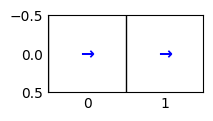

In [16]:
# For BoatEnvSimulator
env = BoatEnvSimulator()
td_solver = TDSolver(env, gamma=0.99, alpha=0.1, epsilon=0.1, episodes=1000, method="sarsa")
policy = td_solver.run()
print("Final policy for BoatEnv:", policy)

# Plot the optimal policy using PolicyPlotter
boat_action_symbols = {0: '←', 1: '→'}
plotter = PolicyPlotter_MC((1, 2), policy, action_symbols=boat_action_symbols)
plotter.plot()


Policy after 0 episodes: {0: 0, 1: 2, 7: 1, 6: 3, 13: 2, 12: 2, 14: 2, 15: 1, 9: 1, 3: 2, 4: 0}
Policy after 100 episodes: {0: 2, 1: 2, 7: 2, 6: 1, 13: 1, 12: 1, 14: 1, 15: 1, 9: 2, 3: 1, 4: 0, 19: 0, 18: 2, 25: 1, 24: 0, 31: 2, 16: 1, 17: 2, 11: 2, 5: 1, 23: 2, 29: 2, 28: 1}
Policy after 200 episodes: {0: 2, 1: 2, 7: 2, 6: 1, 13: 1, 12: 1, 14: 1, 15: 1, 9: 2, 3: 1, 4: 0, 19: 0, 18: 2, 25: 1, 24: 0, 31: 2, 16: 1, 17: 2, 11: 2, 5: 1, 23: 2, 29: 2, 28: 1}
Policy after 300 episodes: {0: 2, 1: 2, 7: 2, 6: 1, 13: 1, 12: 1, 14: 1, 15: 1, 9: 2, 3: 1, 4: 0, 19: 0, 18: 2, 25: 1, 24: 0, 31: 2, 16: 1, 17: 2, 11: 2, 5: 1, 23: 2, 29: 2, 28: 1}
Policy after 400 episodes: {0: 2, 1: 2, 7: 2, 6: 1, 13: 1, 12: 1, 14: 1, 15: 1, 9: 2, 3: 1, 4: 0, 19: 0, 18: 2, 25: 1, 24: 0, 31: 2, 16: 1, 17: 2, 11: 2, 5: 1, 23: 2, 29: 2, 28: 1}
Policy after 500 episodes: {0: 2, 1: 2, 7: 2, 6: 1, 13: 1, 12: 1, 14: 1, 15: 1, 9: 2, 3: 1, 4: 0, 19: 0, 18: 2, 25: 1, 24: 0, 31: 2, 16: 1, 17: 2, 11: 2, 5: 1, 23: 2, 29: 2, 28: 1}

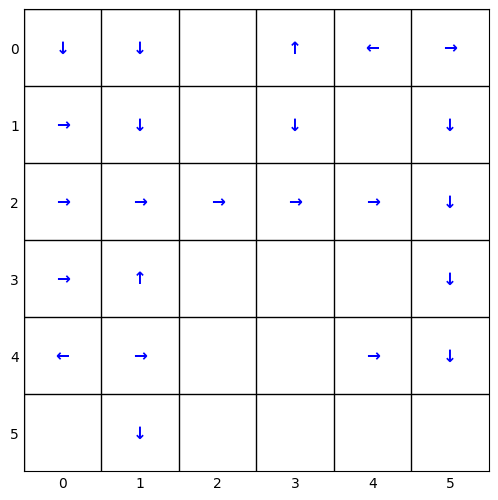

In [17]:
# For GridWorldEnv
env = GridWorldEnv()
td_solver = TDSolver(env, gamma=0.99, alpha=0.1, epsilon=0.1, episodes=1000, method="q_learning")
policy = td_solver.run()
print("Final policy for GridWorldEnv:", policy)

plotter = PolicyPlotter_MC(env.grid_size, policy, walls=env.walls, terminal_states=env.terminal_states)
plotter.plot()


Policy after 0 episodes: {443: 2, 418: 0, 417: 0, 416: 0, 415: 0, 414: 0, 413: 0, 412: 0, 411: 0, 410: 0, 409: 0, 408: 0, 407: 0, 406: 2, 405: 1, 381: 2, 380: 1, 356: 0, 355: 0, 354: 0, 353: 0, 352: 0, 351: 0, 350: 1, 376: 1, 375: 1}
Policy after 100 episodes: {443: 2, 418: 0, 417: 0, 416: 0, 415: 0, 414: 0, 413: 0, 412: 0, 411: 0, 410: 2, 409: 0, 408: 0, 407: 0, 406: 2, 405: 1, 381: 2, 380: 1, 356: 2, 355: 0, 354: 2, 353: 2, 352: 1, 351: 0, 350: 3, 376: 1, 375: 1, 328: 1, 327: 1, 326: 3, 325: 1, 377: 2, 402: 0, 401: 2, 400: 1, 425: 2, 133: 0, 132: 0, 131: 0, 130: 0, 129: 3, 128: 3, 127: 1, 152: 0, 151: 3, 150: 3, 175: 1, 176: 3, 200: 3, 465: 1, 464: 0, 463: 0, 462: 0, 461: 0, 460: 0, 459: 0, 458: 3, 483: 0, 482: 0, 481: 2, 480: 0, 479: 0, 478: 2, 477: 1, 476: 1, 475: 3, 500: 1, 525: 2, 550: 1, 551: 1, 552: 1, 575: 1, 576: 2, 139: 0, 138: 3, 137: 1, 112: 0, 111: 3, 136: 0, 135: 0, 134: 0, 154: 1, 153: 0, 225: 1, 378: 0, 174: 0, 173: 0, 172: 0, 171: 0, 170: 0, 169: 0, 168: 0, 167: 0, 16

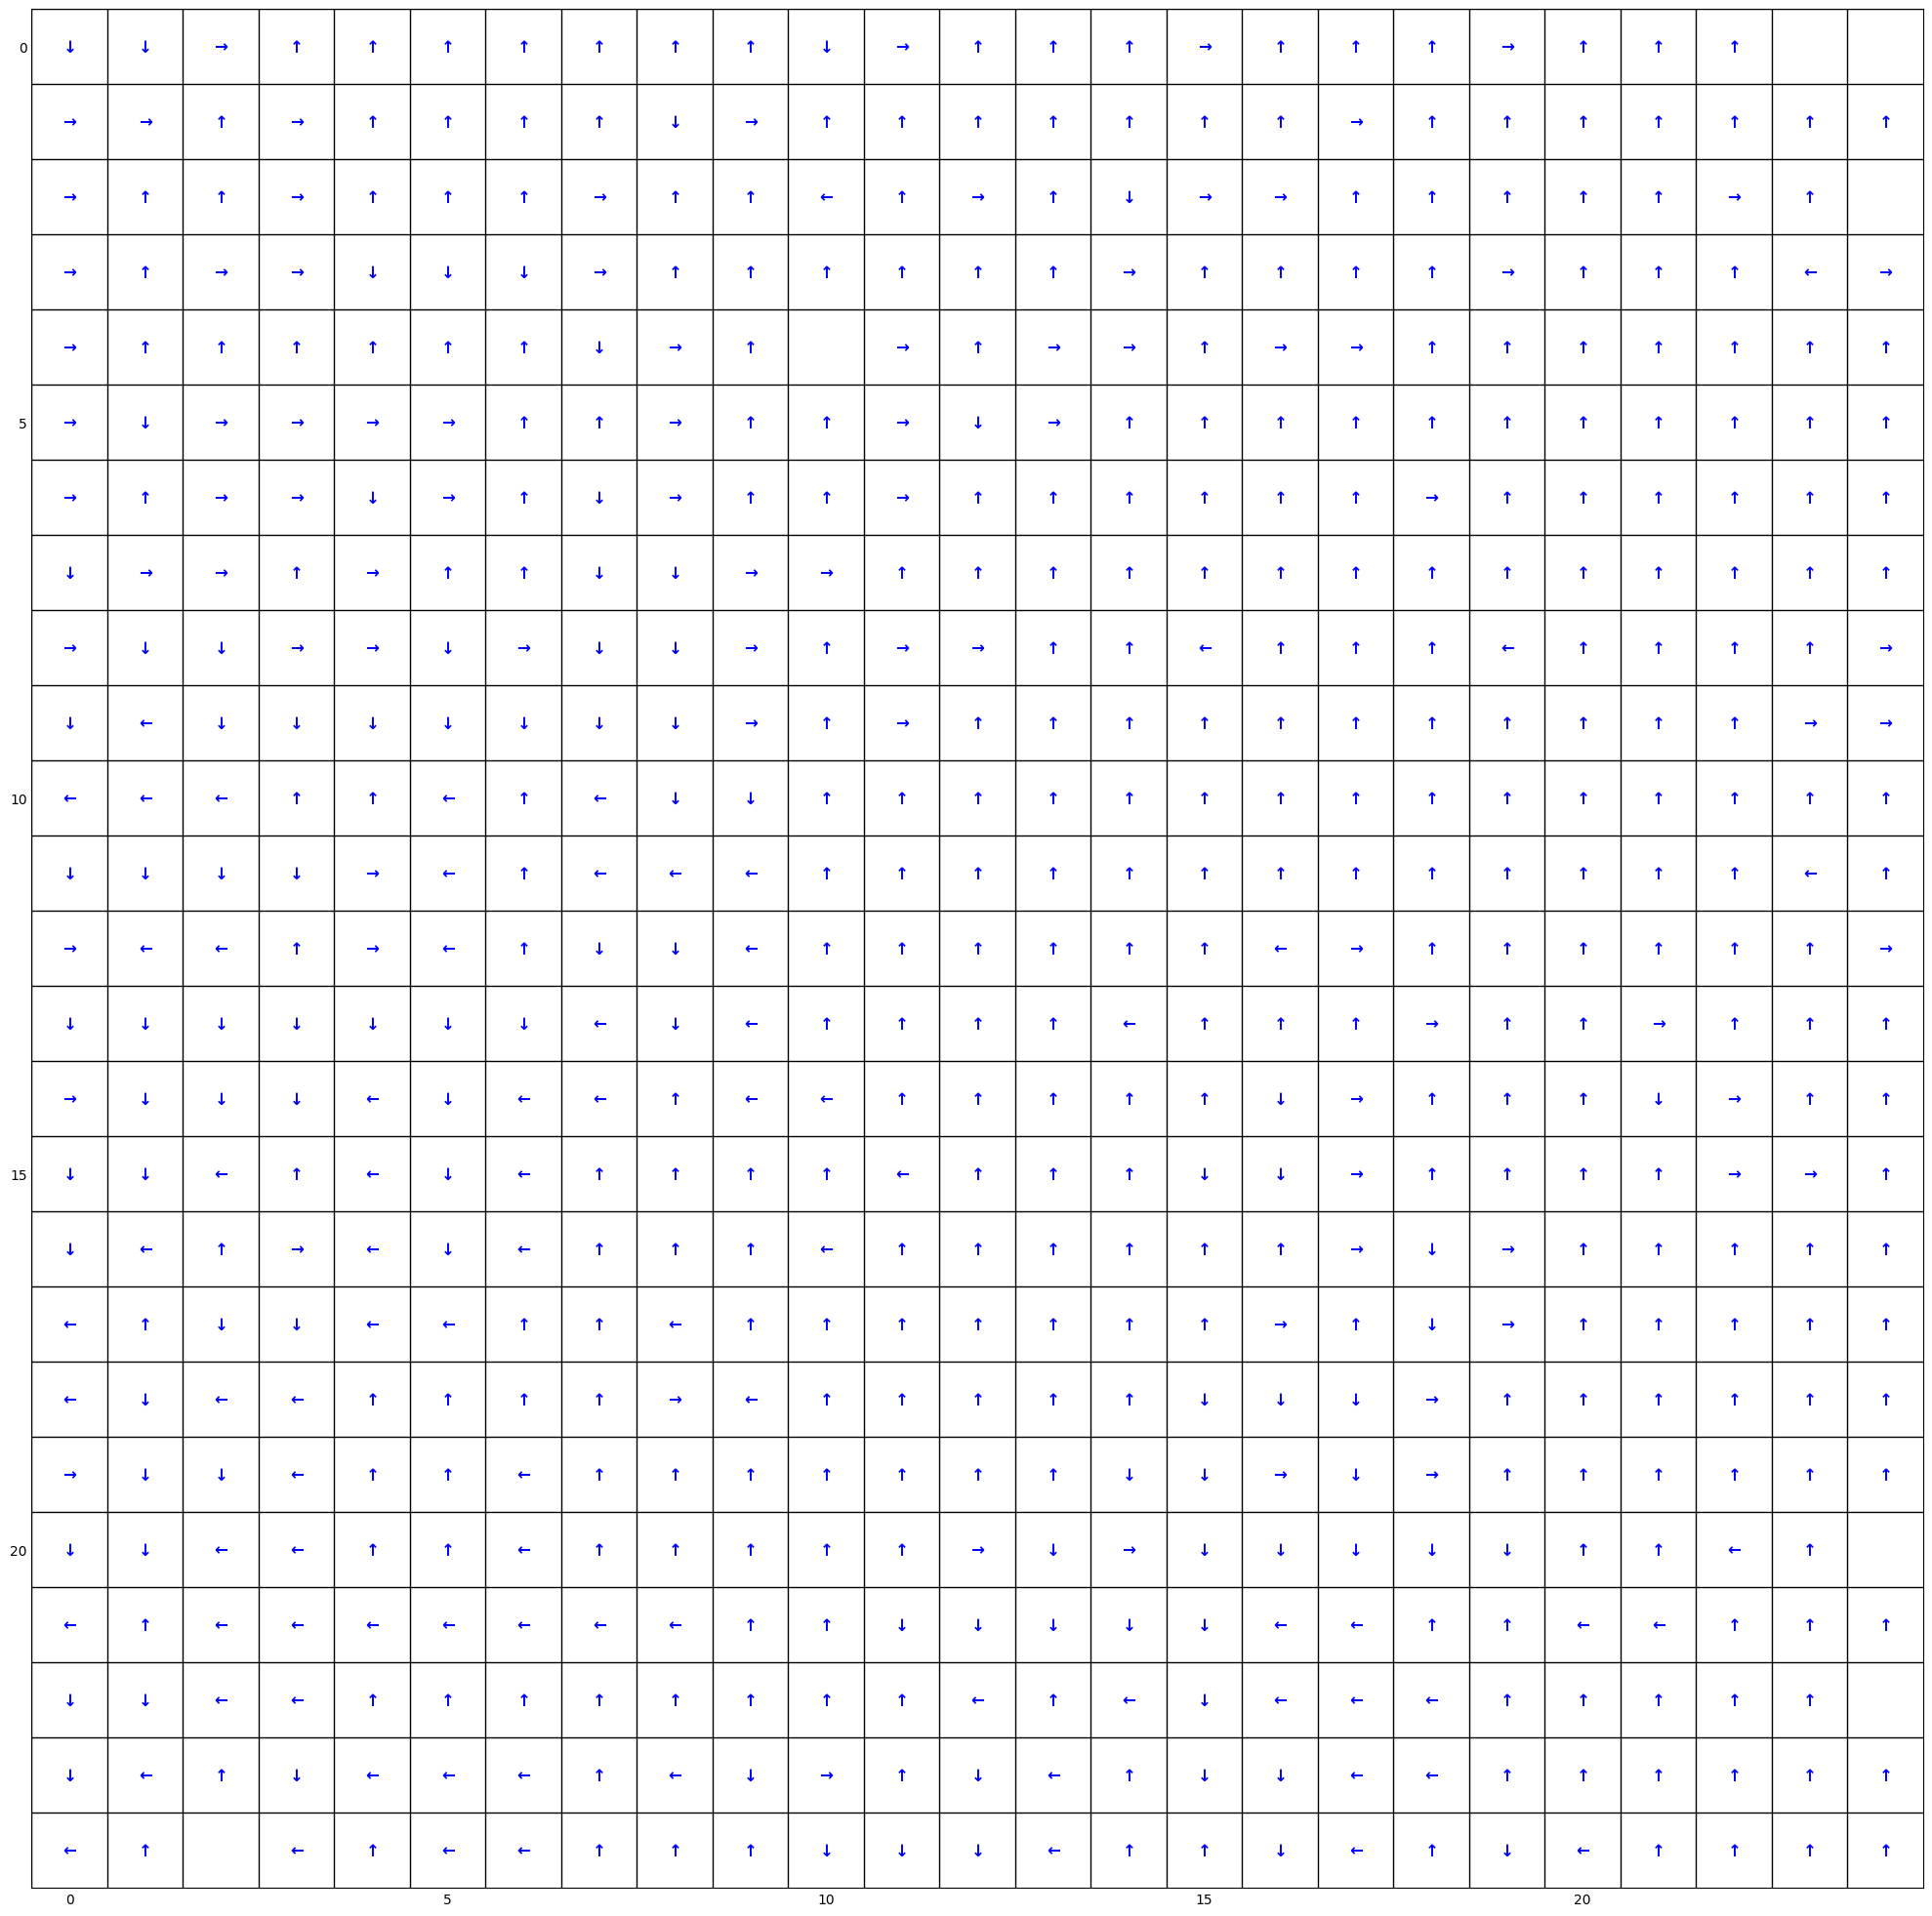

In [19]:
# For GeosearchEnv
env = GeosearchEnv()
td_solver = TDSolver(env, gamma=0.99, alpha=0.1, epsilon=0.1, episodes=1000, method="sarsa")
policy = td_solver.run()
print("Final policy for GeosearchEnv:", policy)

# Plot the optimal policy using PolicyPlotter
action_symbols = {0: '↑', 1: '↓', 2: '←', 3: '→'}
plotter = PolicyPlotter_MC(grid_size=(env.grid_size, env.grid_size), 
                        policy=policy, 
                        walls=[],  # No walls in Geosearch
                        terminal_states=[],  # Add terminal states if defined
                        action_symbols=action_symbols)

plotter.plot()